# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [1]:
# !pip install contractions
# !pip install nltk
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install wordcloud
# !pip install emoji_extractor
# !pip install unidecode
# !pip install textblob
# !pip install lightgbm

In [2]:
# # Download emoji sentiment (Collab)
# !wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
# !unzip allzip
# Instalar la fuente Noto Color Emoji
# !apt-get install -y fonts-noto-color-emoji

In [3]:
import contractions
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy as sp
import spacy
import unidecode
from tqdm import tqdm
tqdm.pandas()

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [4]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

In [5]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
dataset = load_prepare_data(path_data)

In [6]:
dataset

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1
47688,Turner did not withhold his disappointment. Tu...,1
47689,I swear to God. This dumb nigger bitch. I have...,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1


## 2. Análisis exploratorio

### Exploración Básica

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_text     47692 non-null  object
 1   cyberbullying  47692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 745.3+ KB


In [8]:
n_docs = dataset['tweet_text'].count()
print(f'El corpus contiene en total {n_docs} tweets!')

El corpus contiene en total 47692 tweets!


In [9]:
n_duplicados = dataset.duplicated(subset=['tweet_text']).sum()
print(f'El corpus contiene {n_duplicados} tweets duplicados.')

dataset.drop_duplicates(subset=['tweet_text'], ignore_index=True, inplace=True)
print(f'Después de eliminar los duplicados, el corpus mantiene {dataset.shape[0]} tweets.')

El corpus contiene 1675 tweets duplicados.
Después de eliminar los duplicados, el corpus mantiene 46017 tweets.


In [10]:
dataset.isna().sum()

tweet_text       0
cyberbullying    0
dtype: int64

- El dataset no contiene registros nulos!

### Exploración de Contenido

In [11]:
def print_text_random(df, n_text):
    df_sample = df.sample(n_text)
    for i in range(n_text):
        print('Cyberbullying:', df_sample['cyberbullying'].iloc[i])
        print(df_sample['tweet_text'].iloc[i])
        print()

print_text_random(dataset, 10)

Cyberbullying: 1
“@shebad32: “@tayyoung_: FUCK OBAMA, dumb ass nigger” &lt;--- the HATE is still real!” Sheeeesh it's alive

Cyberbullying: 1
i’m a white christian woman. i believe in abortion. i am pro choice. why? because women have the fucking right to choose without someone’s religion getting in the damn way. separation of church and state. pipe the fuck down you arrogant asshole. you’re giving women a bad name.

Cyberbullying: 1
Watching drillbit taylor @PortableShua plays a great bully.

Cyberbullying: 1
It is very easy to pick out individual anecdotes. Any race could do this and pretend racism was institutionalized. The odd incident is not indicative of the wider morality. When did the police start ruling any crime suicide or otherwise? That is the job of the courts.

Cyberbullying: 1
How could straight ppl consent to gay sex? That's not possible. Nice try trying to defend rape jokes tho

Cyberbullying: 1
“@tayyoung_: FUCK OBAMA, dumb ass nigger” Df ?!

Cyberbullying: 1
@AAlwuha

- Nos encontramos con texto con lenguaje informal que contiene menciones (@), hashtags (#), urls y emojis!

In [12]:
# Revisar el balance de las clases:
# Presenta desbalanceo de clases; pocos Non-Cyberbullying tweets!
print(dataset['cyberbullying'].value_counts(), '\n')
print(dataset['cyberbullying'].value_counts(normalize=True))

1    38080
0     7937
Name: cyberbullying, dtype: int64 

1    0.82752
0    0.17248
Name: cyberbullying, dtype: float64


In [13]:
# Comparar textos considerados cyberbullying con los que no los son:
# Filtramos dfs por etiqueta de la variable objetivo.
df_bullying = dataset[dataset.cyberbullying == 1]
df_no_bullying = dataset[dataset.cyberbullying == 0]
# Mostrar 5 tweets al azar por etiqueta.
print_text_random(df_bullying, 5)
print()
print_text_random(df_no_bullying, 5)

Cyberbullying: 1
I await the day that some fucktard from junior high that bullied me for being weird or "looking like a boy" or for dating a girl pops up to me because NOW I'm more attractive or whatever so I can UNLEASH MY RAGE UPON HIM.

Cyberbullying: 1
I didn't say it wasn't a derogatory term, just that it isn't necessarily sexist. When you call a female a bitch, are you really saying anything about her being a female or that she was acting in a way that was pissing you off? Her outrage is purely to politicize the interaction.

Cyberbullying: 1
If you had married that good Christian woman a season or two ago, you wouldn't be sitting on the stoop homeless right now. You would have had some legal recourse. Now you sitting there, broke, homeless and with out a meal ticket at the beginning of cuffing season. Sad.

Cyberbullying: 1
When you lost an argue u start calling confronting stupid , idiot bhala bhala. Just answer a great nation like you ruled by muslims of afghanistan, iran and 

- Después de observar tweets en unas cuantas iteraciones, nos encontramos con **algunos pocos comentarios en otros idiomas** también: español, japonés.
- Los tweets que **no son considerados cyberbullying parecen ser más cortos en longitud** (habrá que comprobarlo más adelante).
- En **tweets de odio/cyberbullying abundan palabras vulgares** derivadas de "fuck", "nigger", "bitch", "buylling", "school", "sex", "Islam".

### Longitud de texto

In [14]:
def count_words(sentence):
    # Tomar únicamente palabras (eliminamos dígitos y puntuaciones).
    sentence_words = re.sub(pattern='[\d\W]', repl=' ', string=sentence)
    # Contar número de palabras en vez de caracteres.
    words = sentence_words.split()
    return len(words)

In [15]:
dataset['count_words'] = dataset['tweet_text'].apply(lambda x: count_words(x))
dataset['count_words']

0         9
1        14
2         9
3        18
4        18
         ..
46012    43
46013    45
46014    21
46015    15
46016    14
Name: count_words, Length: 46017, dtype: int64

In [16]:
dataset.columns

Index(['tweet_text', 'cyberbullying', 'count_words'], dtype='object')

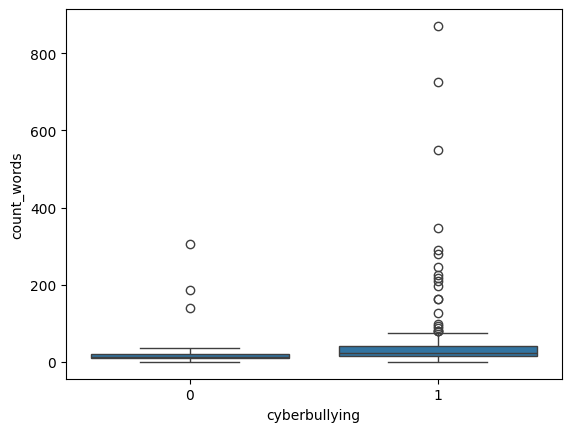

In [17]:
sns.boxplot(data=dataset, y='count_words', x='cyberbullying');

In [18]:
dataset.groupby('cyberbullying')['count_words'].median()

cyberbullying
0    14.0
1    24.0
Name: count_words, dtype: float64

Observaciones:
- Se ha creado una característica que representa la longitud del los tweets (contando únicamente las palabras).
- Se observa la presencia de valores atípicos extremos en Cyberbullying tweets. Por ello, se ha comparado la mediana de la longitud de los tweets, métrica la cual es robusta a la presencia de outliers.
- Al parecer **los Cyberbullying text tienen de mediana 10 palabras más que aquellos no considerados Cyberbullying**.

### Visualización Wordcloud

In [19]:
from wordcloud import WordCloud

text_bullying    = ' '.join(df_bullying.tweet_text.tolist())
text_no_bullying = ' '.join(df_no_bullying.tweet_text.tolist())

# Access the set of stop words for English
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

wordcloud = WordCloud(
    width=900,
    height=550,
    stopwords=stopwords_en,
    background_color='white',
    colormap='viridis_r',
    include_numbers=False,
)

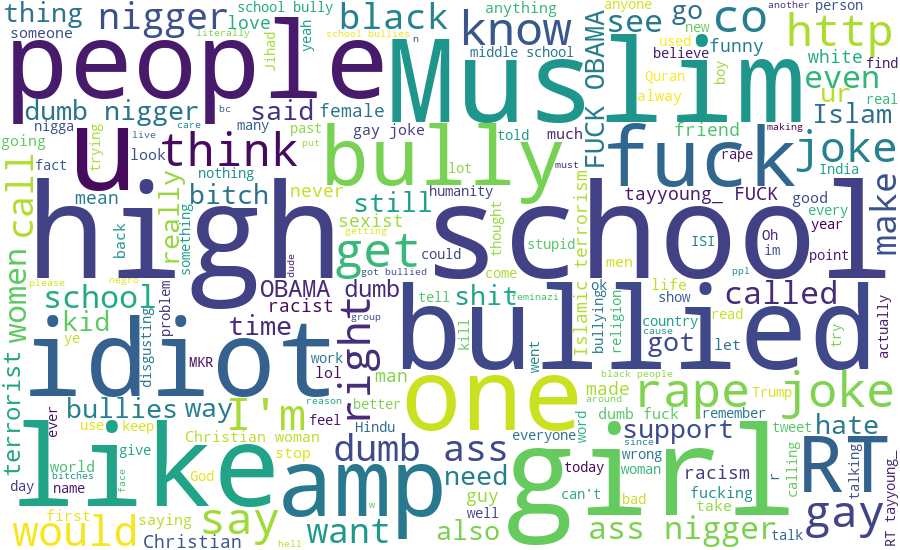

In [20]:
wordcloud.generate(text_bullying)
wordcloud.to_image()

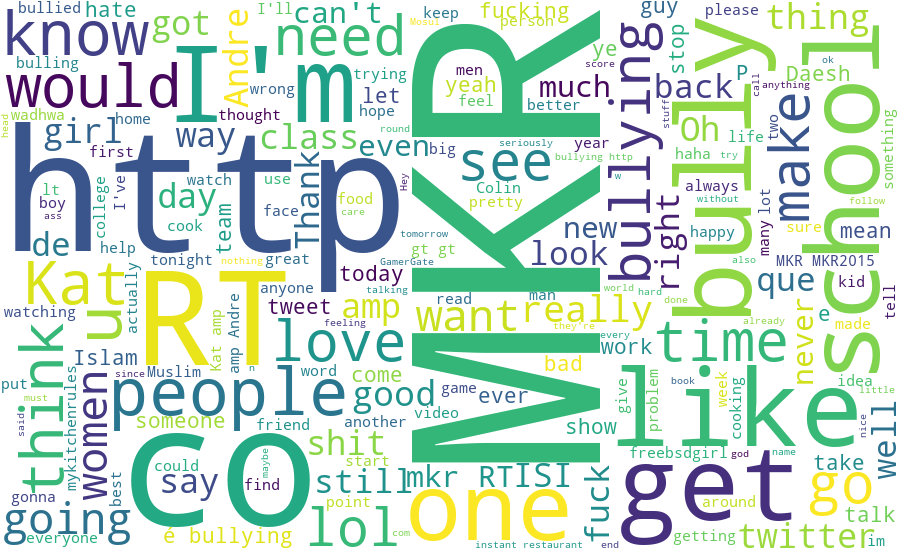

In [21]:
wordcloud.generate(text_no_bullying)
wordcloud.to_image()

Observaciones:
- En cuanto a palabras más frecuentes en los **tweets relacionados con el Cyberbullying**, resaltan palabras como
    - "high school", "bullied", "like", e
    - insultos: "idiot", "dumb ass", "fuck".
    - En relación a aquellas palabras vinculadas a las víctimas del discurso de odio: "girl", "rape", "Muslim", "Islamic terrorism", "gay", "gay rape", "nigger", "dumb nigger", "FUCK OBAMA", entre otros.

- Por otro lado, en **tweets no considerados como Cyberbullying**, abundan la presencia de palabras como "MKR", "CO", de los cuales desconozco el significado.
    - Abundan también términos como "http", el cual hace referencia a enlaces URLs.

### Exploración de Emojis

In [22]:
# Función para extraer emojis del texto en formato lista.
from emoji_extractor.extract import Extractor

def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

dataset["emojis"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))

In [23]:
print('Número de tweets sin emojis:', dataset["emojis"].apply(lambda x: len(x) == 0).sum())
print('Número de tweets con emojis:', dataset["emojis"].apply(lambda x: len(x) > 0).sum())

Número de tweets sin emojis: 45606
Número de tweets con emojis: 411


In [24]:
# Número de emojis por tweet.
dataset['count_emojis'] = dataset['emojis'].apply(lambda x: len(x))
dataset['count_emojis'].value_counts()

0    45606
1      327
2       54
3       18
4        4
7        3
5        2
6        2
8        1
Name: count_emojis, dtype: int64

In [25]:
n_tweets_emojis_no_bullying = dataset[(dataset['cyberbullying'] == 0) & (dataset["emojis"].apply(lambda x: len(x) > 0))].shape[0]
n_tweets_emojis_bullying = dataset[(dataset['cyberbullying'] == 1) & (dataset["emojis"].apply(lambda x: len(x) > 0))].shape[0]
print(f'Cyberbullying tweets contiene en total {n_tweets_emojis_bullying} tweets con emoji/s.')
print(f'Non-Cyberbullying tweets contiene en total {n_tweets_emojis_no_bullying} tweets con emoji/s.')

Cyberbullying tweets contiene en total 187 tweets con emoji/s.
Non-Cyberbullying tweets contiene en total 224 tweets con emoji/s.


In [26]:
# Emojis más comunes por clase.
lista_anidada_mojis_bullying    = dataset[dataset.cyberbullying == 1]['emojis'].tolist()
lista_anidada_mojis_no_bullying = dataset[dataset.cyberbullying == 0]['emojis'].tolist()


lista_emojis_bullying    = [emoji for sublist in lista_anidada_mojis_bullying for emoji in sublist]
lista_emojis_no_bullying = [emoji for sublist in lista_anidada_mojis_no_bullying for emoji in sublist]

print(f"Cyberbullying text contiene en total {len(lista_emojis_bullying)} emojis.")
print(f"Non-Cyberbullying text contiene en total {len(lista_emojis_no_bullying)} emojis.")

Cyberbullying text contiene en total 239 emojis.
Non-Cyberbullying text contiene en total 317 emojis.


In [27]:
from collections import Counter

# Crear un diccionario de emojis con conteos.
dict_emojis_bullying = Counter(lista_emojis_bullying)
dict_emojis_no_bullying = Counter(lista_emojis_no_bullying)

# Escojer los top 10 emojis para cada etiqueta. 
tupla_top_emojis_bullying = sorted(dict_emojis_bullying.items(), key=lambda x: x[1], reverse=True)[:10]
top_emojis_bullying       = list(map(lambda x: x[0], tupla_top_emojis_bullying))
top_counts_bullying       = list(map(lambda x: x[1], tupla_top_emojis_bullying))

tupla_top_emojis_no_bullying = sorted(dict_emojis_no_bullying.items(), key=lambda x: x[1], reverse=True)[:10]
top_emojis_no_bullying       = list(map(lambda x: x[0], tupla_top_emojis_no_bullying))
top_counts_no_bullying       = list(map(lambda x: x[1], tupla_top_emojis_no_bullying))

In [28]:
top_emojis_bullying

['❤', '😂', '©', '😘', '♥', '😳', '😊', '😉', '😒', '®']

In [29]:
top_emojis_no_bullying

['😂', '❤', '♥', '😊', '😘', '😁', '😍', '👌', '👍', '😡']

C:\Users\milow\AppData\Local\Temp\ipykernel_13868\2806620129.py:9: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\milow\AppData\Local\Temp\ipykernel_13868\2806620129.py:9: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\milow\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\milow\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


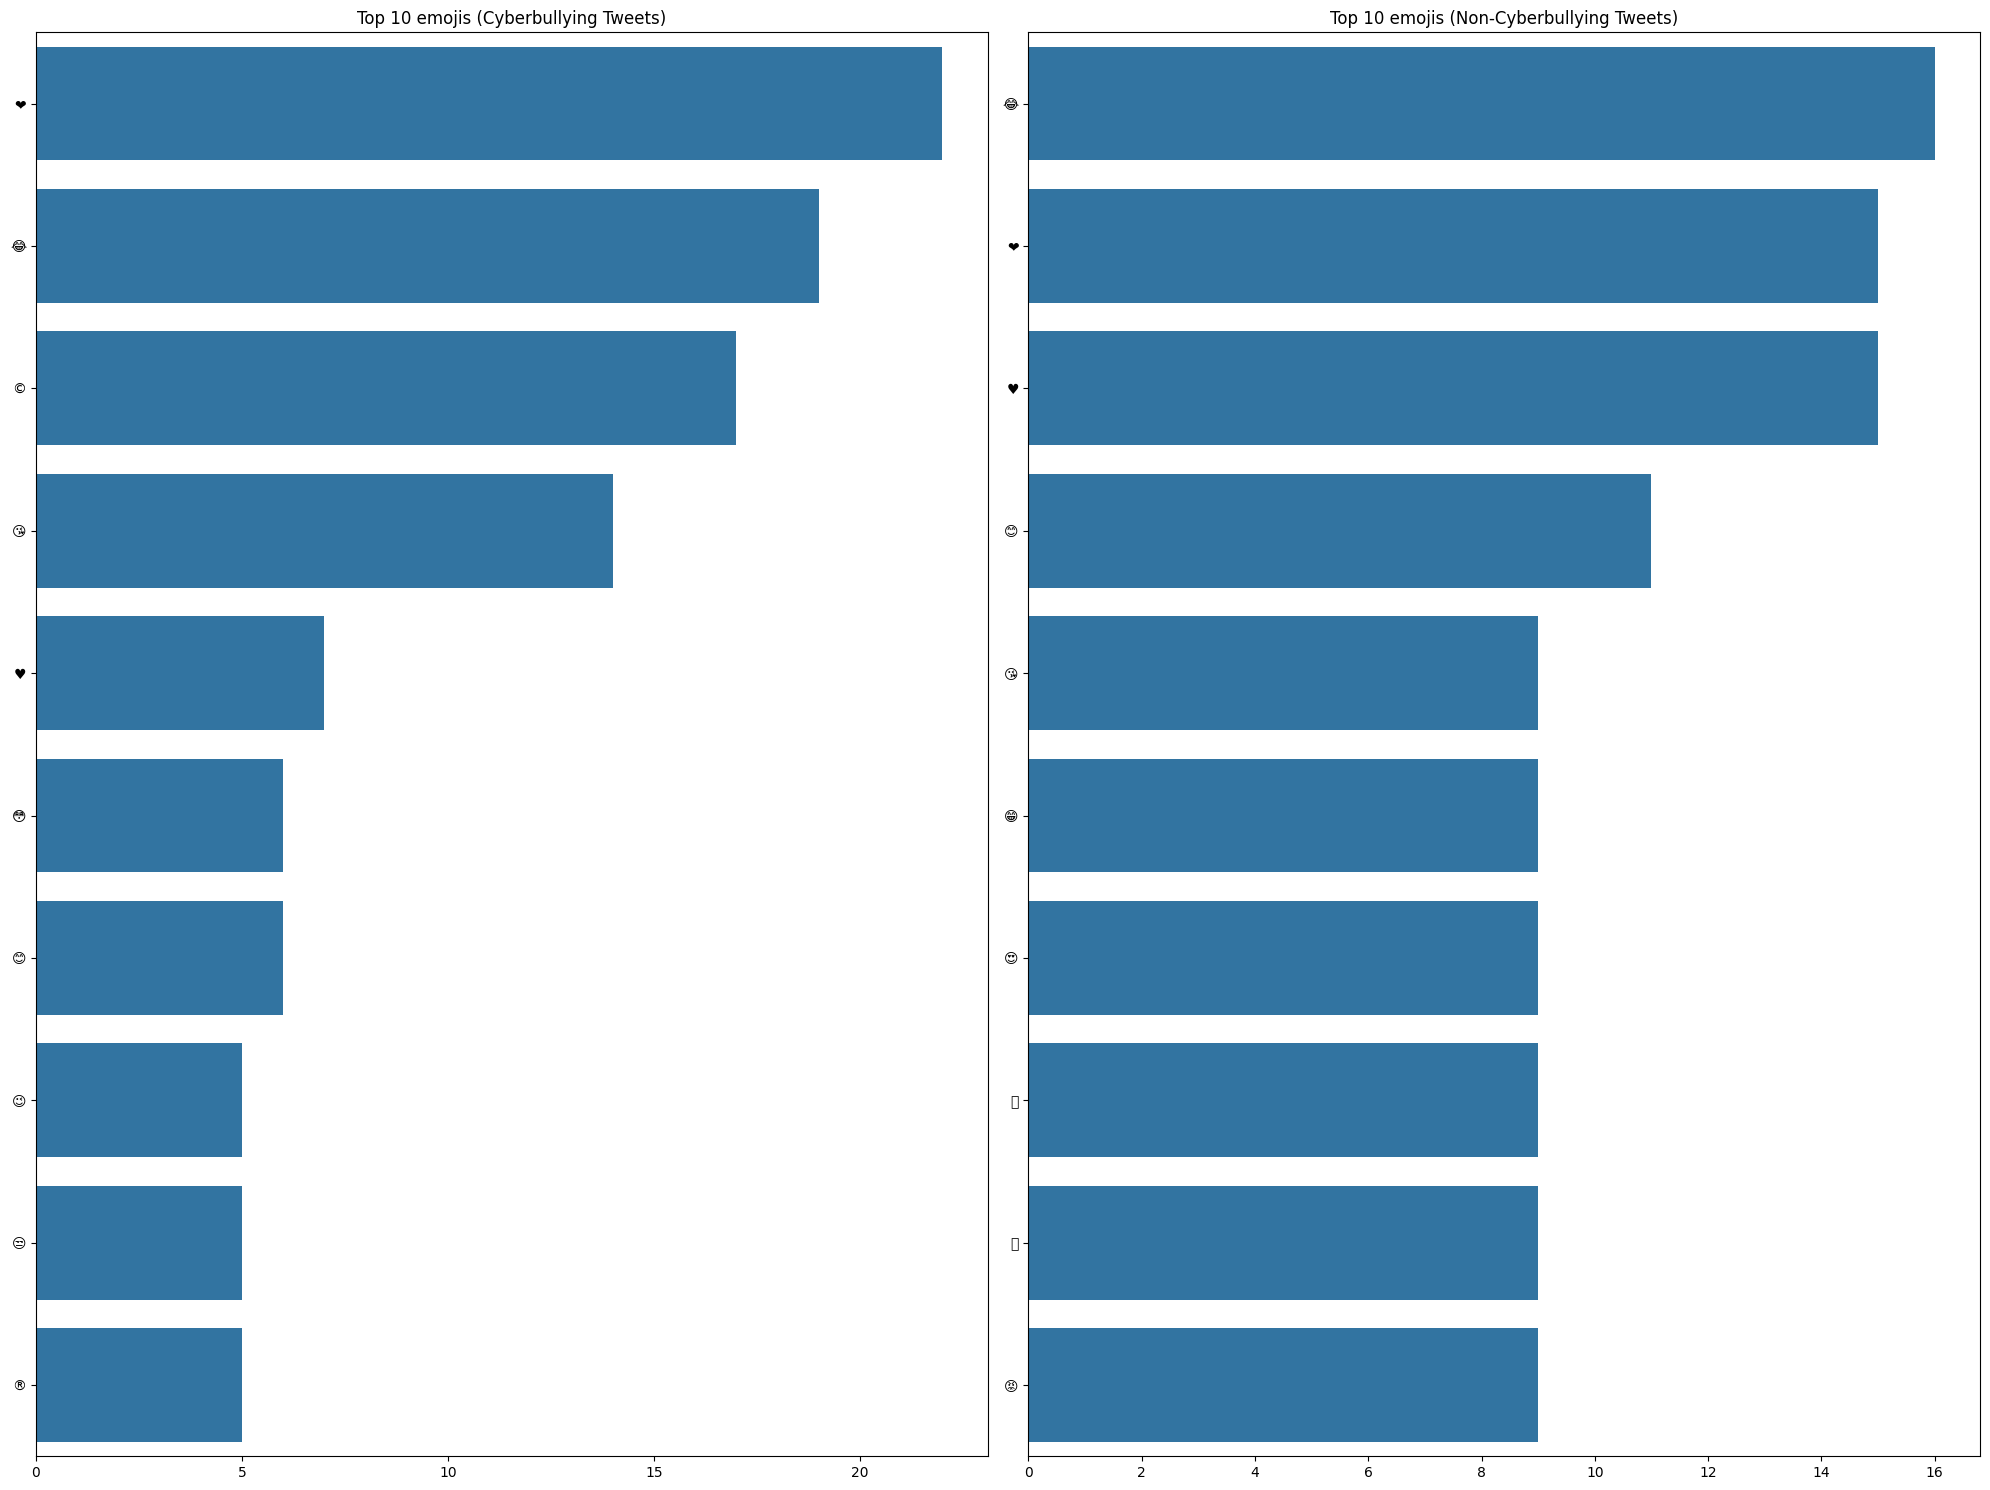

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

sns.barplot(y=top_emojis_bullying, x=top_counts_bullying, ax=axes[0])
axes[0].set_title('Top 10 emojis (Cyberbullying Tweets)')

sns.barplot(y=top_emojis_no_bullying, x=top_counts_no_bullying, ax=axes[1])
axes[1].set_title('Top 10 emojis (Non-Cyberbullying Tweets)')

plt.tight_layout()
plt.show()

- Muchos de los emojis más frecuentes son comunes tanto en Cyberbullying comon en Non-Cyberbullying tweets: 😂', '❤', '♥', '😊', '😘'.
- **Tiene pinta que las variables relacionadas con los emojis no van a ser muy predictivos** en nuestra tarea de clasificación:
    - Muy pocos tweets con emojis en relación con el total de tweets (411 de 46017).
    - Conteos similares de emojis en las etiquetas de la target (239 de Cyberbullying frente a 317 de Non-Cyberbullying).
    - Los emojis más frecuentes son comunes en ambas etiquetas de la target.

## 3. Preprocesado y Normalización

### Preprocesado

In [31]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

# definir función para tokenizar social media text (función clase con modificaciones):
def normalize_SocialMediaText(sentence):
    # Pasar a minúscula.
    sentence = sentence.lower()
    # Reemplazar contracciones.
    sentence = contractions.fix(sentence, slang=True)
    # Tokenizar social media content.
    tokens_tweet = tweet_tokenizer.tokenize(sentence)

    # Normalizar componentes propios de social media text:
    #hashtags, mentions, urls, números.
    # Duplicamos la última letra de dichos componentes normalizados
    #para evitar matches dentro del corpus: hashtagg, mentionn, urll, numberr.
    for i, token in enumerate(tokens_tweet):
        if token.startswith('#'):
            tokens_tweet[i] = 'hashtagg'
        elif token.startswith('@'):
            tokens_tweet[i] = 'mentionn'
        elif token.startswith('http://') or token.startswith('https://') or token.startswith('www.'):
            tokens_tweet[i] = 'urll'
        elif token.isdigit():
            tokens_tweet[i] = 'numberr'

    # Unir las palabras de nuevo en un documento modificado
    sentence_modified = ' '.join(tokens_tweet)
    return sentence_modified

In [32]:
# Tokenizar y normalizar social media text:
dataset['text_normalized'] = dataset['tweet_text'].apply(lambda x: normalize_SocialMediaText(x))
dataset['text_normalized']

0        in other words hashtagg , your food was crapil...
1        why is hashtagg so white ? hashtagg hashtagg h...
2        mentionn a classy whore ? or more red velvet c...
3        mentionn meh . :p thanks for the heads up , bu...
4        mentionn this is an isis account pretending to...
                               ...                        
46012    black people are not expected to do anything ,...
46013    turner did not withhold his disappointment . t...
46014    i swear to god . this dumb nigger bitch . i ha...
46015    yea fuck you rt mentionn : if you are a nigger...
46016    bro . you got to chill rt mentionn : dog fuck ...
Name: text_normalized, Length: 46017, dtype: object

In [33]:
# Lematizar, eliminar puntuaciones, stopwords y espacios:
nlp = spacy.load('en_core_web_sm')
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS

def preprocess_text(sentence):
    # Reemplazar vocales con acentos, convertir Non-ASCII a ASCII characters.
    sentence = unidecode.unidecode(sentence, errors='preserve')
    # Quitamos numeros y puntuaciones del raw string por RegExp.
    sentence = re.sub(pattern='[\d\W]',repl=' ', string=sentence)
    # Pasamos la frase por el objeto nlp para procesarla.
    spacy_doc = nlp(sentence)
    # Lematizar y quitar los stopwords y espacio.
    mytokens = [word.lemma_ for word in spacy_doc if word.text not in stopwords_spacy]
    # Remove extra spaces.
    mytokens = [token.strip() for token in mytokens]
    # Remove '' token.
    mytokens = [token for token in mytokens if token != '']
    
    return ' '.join(mytokens)

In [34]:
dataset['text_preprocessed'] = dataset['text_normalized'].apply(lambda x: preprocess_text(x))
dataset['text_preprocessed']

0                 word hashtagg food crapilicious hashtagg
1        hashtagg white hashtagg hashtagg hashtagg hash...
2                 mentionn classy whore red velvet cupcake
3        mentionn meh p thank head concerned angry dude...
4        mentionn isis account pretend kurdish account ...
                               ...                        
46012    black people expect depend free participate wo...
46013    turner withhold disappointment turner call cou...
46014    swear god dumb nigger bitch get bleach hair re...
46015    yea fuck rt mentionn nigger fucking unfollow f...
46016    bro get chill rt mentionn dog fuck kp dumb nig...
Name: text_preprocessed, Length: 46017, dtype: object

In [35]:
# Revisar las trasformaciones de texto:
df_sample = dataset.sample(5)
for i in range(len(df_sample)):
    print('\033[1mText Original\033[0m:')
    print(df_sample.iloc[i]['tweet_text'])
    print('\033[1mText Normalized\033[0m:')
    print(df_sample.iloc[i]['text_normalized'])
    print('\033[1mText Preprocessed\033[0m:')
    print(df_sample.iloc[i]['text_preprocessed'])
    print()

Text Original:
all of the girls that bullied me in high school now have kids lol,,, praying for their children.
Text Normalized:
all of the girls that bullied me in high school now have kids lol , , , praying for their children .
Text Preprocessed:
girl bully high school kid lol pray child

Text Original:
@_Kittttty: “@_LexiJosephine: This bitch ... RT @tayyoung_: FUCK OBAMA, dumb ass nigger” shmack shmack im ashamed to be white now..
Text Normalized:
mentionn : “ mentionn : this bitch ... rt mentionn : fuck obama , dumb ass nigger ” shmack shmack i am ashamed to be white now ..
Text Preprocessed:
mentionn mentionn bitch rt mentionn fuck obama dumb ass nigger shmack shmack ashamed white

Text Original:
@HeatherMoAndCo @LostSailorNY @Shermertron Please explain what the .77 figure cited in wage gap discussions compares.  Thanks.
Text Normalized:
mentionn mentionn mentionn please explain what the . numberr figure cited in wage gap discussions compares . thanks .
Text Preprocessed:
mention

### Wordcloud (texto preprocesado)

In [36]:
wordcloud = WordCloud(
    width=900,
    height=550,
    stopwords=None,
    background_color='white',
    colormap='viridis_r',
    collocations=False,
    include_numbers=False,
)

text_prep_bullying    = ' '.join(dataset[dataset.cyberbullying == 1].text_preprocessed.tolist())
text_prep_no_bullying = ' '.join(dataset[dataset.cyberbullying == 0].text_preprocessed.tolist())

print(f'Cyberbullying preprocessed text contiene en total {len(text_prep_bullying)} caracteres.')
print(f'Non-Cyberbullying preprocessed text contiene en total {len(text_prep_no_bullying)} caracteres.')

Cyberbullying preprocessed text contiene en total 3218371 caracteres.
Non-Cyberbullying preprocessed text contiene en total 401248 caracteres.


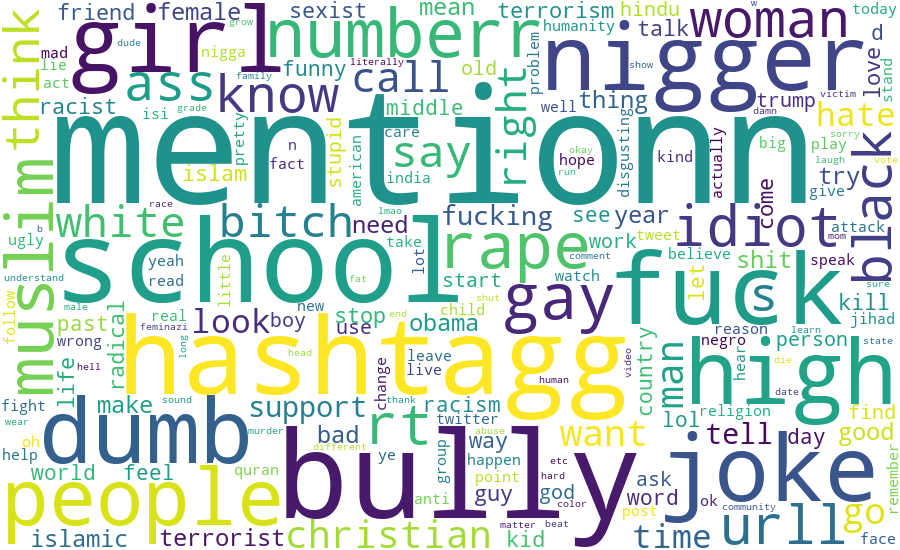

In [37]:
wordcloud.generate(text_prep_bullying)
wordcloud.to_image()

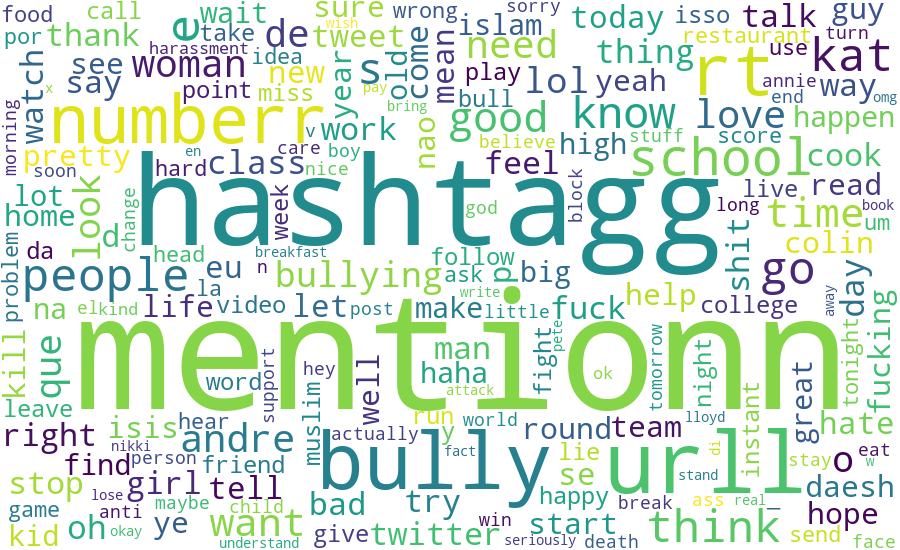

In [38]:
wordcloud.generate(text_prep_no_bullying)
wordcloud.to_image()

Observaciones:
- En **Cyberbullying text**, se observan muchas menciones (@), palabras como "bully", "school", "girl", "gay", "muslim", "bitch", "rape", "fuck", "nigger", "idiot".
- En **Non-Cyberbullying text**, abundan sobre todo menciones (mentionn), hashtags (hashtagg), urls (urll) y retweets (rt).
- Se observa claramente que en Cyberbullying text se utilizan unas pocas palabras con mucha más frecuencia que en **Non-cyberbullying text, el cual presenta mucha más diversidad en el uso de palabras**; vocabulario.
- Viendo ambos wordclouds, parece ser se utilizan **más nombres y adjetivos en Cyberbullying text** que en Non-Cyberbullying text. Por otro lado, **éste último presenta más verbos relativamente**.

## 4. Feature Engineering

### Part-Of-Speech

In [39]:
# Función que realiza el conteo total de una de las Part-Of-Speech ('NOUN', ADJ', VERB') de una frase.
def get_pos_count(sentence, pos):
    sentence = nlp(sentence)
    return len([token for token in sentence if token.pos_ == pos])

In [40]:
# Añadir conteos de sustantivos, adjetivos y verbos como nuevas características:
dataset['count_noun'] = dataset['text_normalized'].progress_apply(lambda x: get_pos_count(x, 'NOUN'))
dataset['count_adj']  = dataset['text_normalized'].progress_apply(lambda x: get_pos_count(x, 'ADJ'))
dataset['count_verb'] = dataset['text_normalized'].progress_apply(lambda x: get_pos_count(x, 'VERB'))

100%|██████████| 46017/46017 [03:22<00:00, 227.11it/s]


### Social Media Components

In [41]:
# Utilizamos la función de la clase:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

In [42]:
# Añadir conteos de menciones, hashtags y urls como nuevas características:
dataset["count_mention"] = dataset['text_preprocessed'].progress_apply(lambda x: token_appearance(x, token="mentionn"))
dataset["count_hashtag"] = dataset['text_preprocessed'].progress_apply(lambda x: token_appearance(x, token="hashtagg"))
dataset["count_url"]     = dataset['text_preprocessed'].progress_apply(lambda x: token_appearance(x, token="urll"))
dataset["count_num"]     = dataset['text_preprocessed'].progress_apply(lambda x: token_appearance(x, token="numberr"))

100%|██████████| 46017/46017 [00:00<00:00, 484405.13it/s]


### Emojis Sentiment

In [43]:
# Preparar diccionario de emojis (función de la clase).
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

# Creamos un diccionario de emojis con sus sentimientos.
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

# Utilizamos la función de la clase para sacar el sentimiento promedio de los emojis:
def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e:
      continue

  if len(lista)>=1:
    longitud = len(lista)
  else:
    longitud =1
  return output/ longitud

In [44]:
dataset["sent_emoji_pos"] = dataset["emojis"].progress_apply(lambda x: get_emoji_sentiment(x, "positive"))
dataset["sent_emoji_neu"] = dataset["emojis"].progress_apply(lambda x: get_emoji_sentiment(x, "neutral"))
dataset["sent_emoji_neg"] = dataset["emojis"].progress_apply(lambda x: get_emoji_sentiment(x, "negative"))

100%|██████████| 46017/46017 [00:00<00:00, 1243945.16it/s]


### Text Sentiment

In [45]:
from textblob import TextBlob
dataset["text_sentiment_polarity"] = dataset["text_preprocessed"].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["text_sentiment_subjectivity"] = dataset["text_preprocessed"].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)

100%|██████████| 46017/46017 [00:04<00:00, 10326.80it/s]


### Comparación target y labels

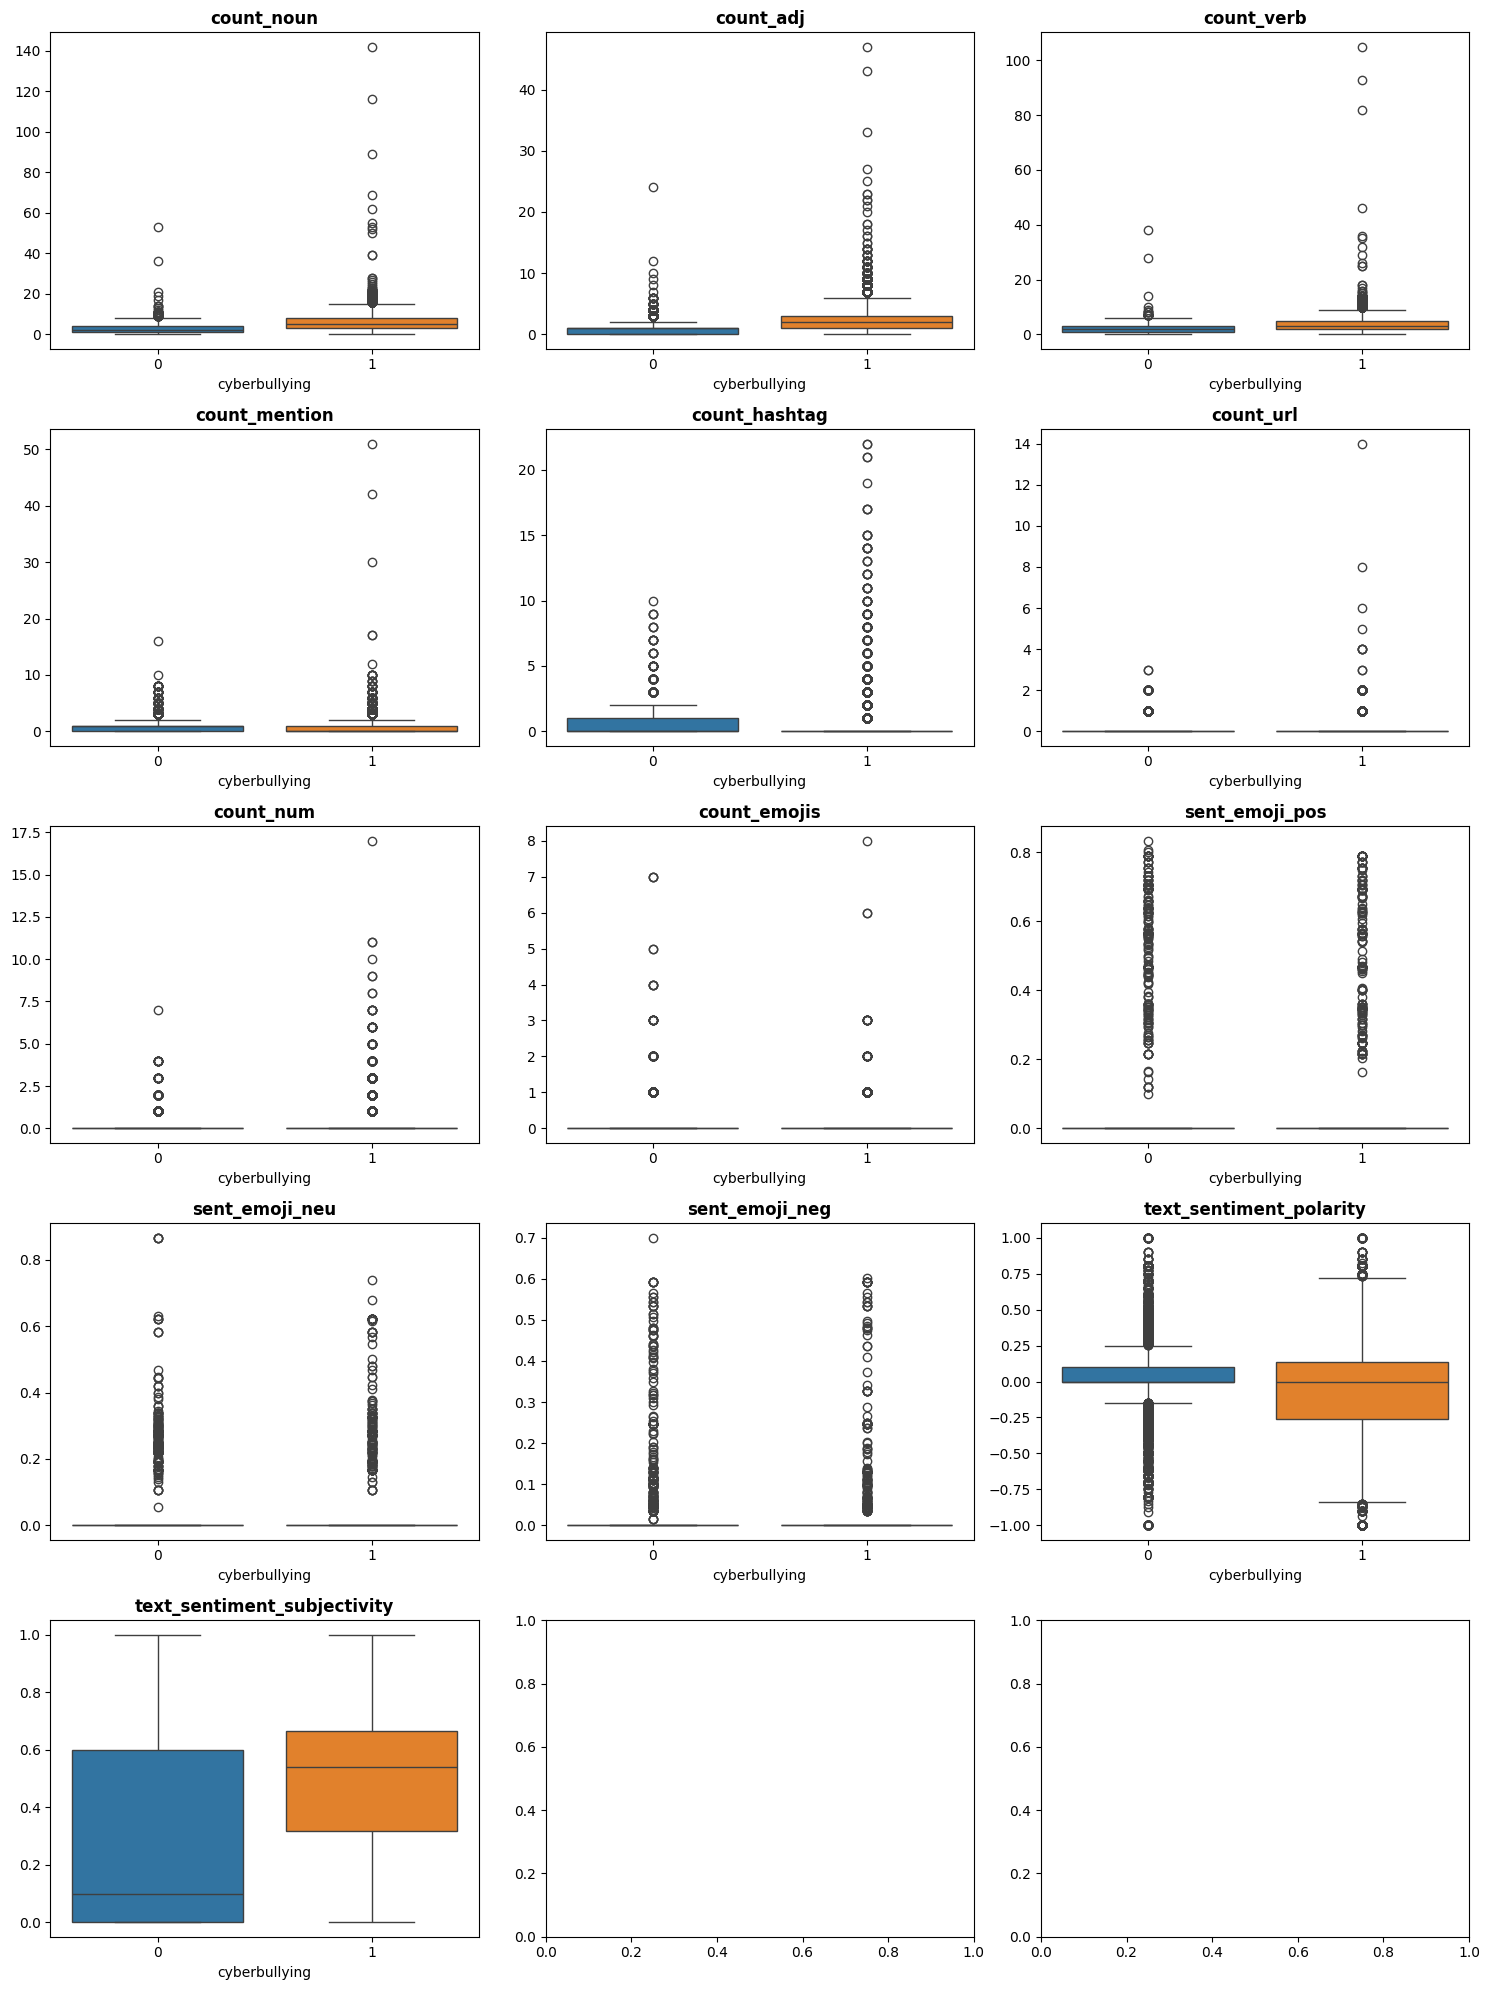

In [46]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

vars = [
    'count_noun', 'count_adj', 'count_verb',
    'count_mention', 'count_hashtag', 'count_url', 'count_num',
    'count_emojis', 'sent_emoji_pos', 'sent_emoji_neu', 'sent_emoji_neg',
    'text_sentiment_polarity', 'text_sentiment_subjectivity'
]
# hue y legend por este warning:
# Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.
#Assign the `x` variable to `hue` and set `legend=False` for the same effect.
for i, var in enumerate(vars):
    sns.boxplot(
        data=dataset,
        y=var,
        x='cyberbullying',
        palette='tab10',
        hue='cyberbullying',
        legend=False,
        ax=axes[i]
    )
    axes[i].set_title(var, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('')
plt.tight_layout()

In [47]:
for _, var in enumerate(vars):
    print(dataset.groupby('cyberbullying')[var].median())
    print()

cyberbullying
0    2.0
1    5.0
Name: count_noun, dtype: float64

cyberbullying
0    1.0
1    2.0
Name: count_adj, dtype: float64

cyberbullying
0    2.0
1    3.0
Name: count_verb, dtype: float64

cyberbullying
0    1.0
1    0.0
Name: count_mention, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: count_hashtag, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: count_url, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: count_num, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: count_emojis, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: sent_emoji_pos, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: sent_emoji_neu, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: sent_emoji_neg, dtype: float64

cyberbullying
0    0.0
1    0.0
Name: text_sentiment_polarity, dtype: float64

cyberbullying
0    0.10
1    0.54
Name: text_sentiment_subjectivity, dtype: float64



Observaciones:
- Al igual que la longitud de los tweets ("count_words"), todas las características generadas presentan muchos valores atípicos, dificultando la visualización de la comparación de sus promedios entre las dos etiquetas de la target.

- Siguiendo la estrategia anterior, hemos recurrido a comparar la mediana de las características frente la target "cyberbullying":
    - En cuanto a POS, los tweets de odio presentan contienen más sustantivos, adjetivos, y verbos que los que no son considerados Cyberbullying. Esto **podría indicar simplemente que los tweets de odio son más extensos que su contraparte**.
    - **En cuanto a componentes de redes sociales y sentimiento promedio de emojis, no se aprecia gran capacidad discriminatoria** entre las etiquetas de la target puesto que en todas estas variables, la mediana es 0.
    - **La única característica generada prometedora es "text_sentiment_subjectivity"**. Al parecer, los tweets de odio son, de mediana, mucho más subjetivas que los Non-Cyberbullying tweets.

### Guardar dataset with new features

- **Vamos a guardar el DataFrame con textos preprocesados y nuevas características para ahorrar coste computacional** al correr otra vez las celdas de nuevo!

In [48]:
# dataset.to_pickle('dataset_with_NewFeatures.pkl')

In [49]:
dataset = pd.read_pickle('dataset_with_NewFeatures.pkl')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46017 entries, 0 to 46016
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tweet_text                   46017 non-null  object 
 1   cyberbullying                46017 non-null  int64  
 2   emojis                       46017 non-null  object 
 3   count_emojis                 46017 non-null  int64  
 4   text_normalized              46017 non-null  object 
 5   text_preprocessed            46017 non-null  object 
 6   count_words                  46017 non-null  int64  
 7   count_noun                   46017 non-null  int64  
 8   count_adj                    46017 non-null  int64  
 9   count_verb                   46017 non-null  int64  
 10  count_mention                46017 non-null  int64  
 11  count_hashtag                46017 non-null  int64  
 12  count_url                    46017 non-null  int64  
 13  count_num       

## 5. Vectorización

### Vectorización: TF-IDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizador_tfidf = TfidfVectorizer(
    lowercase=False,
    stop_words =None,
    min_df=0.005,
    ngram_range = (1,3),
    use_idf=True,
    smooth_idf=True,
)

data_vectorized = vectorizador_tfidf.fit_transform(dataset["text_preprocessed"])
data_vectorized

<46017x366 sparse matrix of type '<class 'numpy.float64'>'
	with 341427 stored elements in Compressed Sparse Row format>

### Añadir nuevas características

In [51]:
features_extra = [
    'count_words', 'count_noun', 'count_adj', 'count_verb',
    'count_mention', 'count_hashtag', 'count_url', 'count_num',
    'count_emojis', 'sent_emoji_pos', 'sent_emoji_neu', 'sent_emoji_neg',
    'text_sentiment_polarity', 'text_sentiment_subjectivity',
]

len(features_extra)

14

In [52]:
X = sp.sparse.hstack((data_vectorized, dataset[features_extra].values), format="csr")
X

<46017x380 sparse matrix of type '<class 'numpy.float64'>'
	with 613341 stored elements in Compressed Sparse Row format>

In [53]:
X_col_names = vectorizador_tfidf.get_feature_names_out().tolist() + features_extra
print(f"Finalmente, terminamos con {len(X_col_names)} features en nuesto espacio de características!")

Finalmente, terminamos con 380 features en nuesto espacio de características!


## 6. Entrenamiento y evaluación de modelos


### Train-Test Split

In [54]:
# Definir y:
y = dataset['cyberbullying'].values
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(f"Training set shapes (X, y): {X_train.shape}, {y_train.shape}")
print(f"Test set shapes (X, y)    : {X_test.shape}, {y_test.shape}")

Training set shapes (X, y): (36813, 380), (36813,)
Test set shapes (X, y)    : (9204, 380), (9204,)


### Elección de modelos

- Dentro de los algoritmos de Naive Bayes, **vamos a probar "MultinomialNB" y "The Complement Naive Bayes classifier"**. Estos dos algoritmos asumen que los datos tienen una distribución multinomial, el cual es idóneo para variables que representan conteos y frecuencias. Además, funcionan con frecuencias fraccionadas también (TF-IDF). Éste último, ComplementNB, parecer funcionar mejor en datos imbalanceados, además de ser más laxo en cuanto a asunciones del modelo MultinomialNB. Basado en información de ["Sklearn Source"](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).
    - **Descartamos GaussianNB** ya que hemos visto y sabemos que las distribuciones de los conteos y valores TF-IDF están muy lejos de ser normales. Vamos a probarlo igualmente para ver la diferencia en los resultados con los otros algoritmos de NB. Los modelos de NB son muy eficientes computacionalmente.

- **Probaremos con regresión logística** también. Se entrena relativamente rápido, los coeficientes de las variables proporcionan información de la importancia de variables, y maneja bien datos binarios (presencia o no de palabras).
- Dentro de los algoritmos de boosting (capturar efectos no lineales entre Xs e y), **vamos a escoger LigthGBM**, sobre todo por ser más eficiente computacionalmente que el resto de los ensemble. Posibilidad de sacar Feature Importance de las variables.

In [56]:
# Identificamos la columna con valores negativos en el array: 'text_sentiment_polarity'
# La eliminaremos para MultinomialNB y ComplementNB, modelos que no aceptan valores negativos!
# Se trata de la penúltima columna del np.array:
(X_train.toarray()[:, -2] < 0).any()  # Hay por lo menos un valor negativo! -> 'text_sentiment_polarity'

True

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# Instanciamos los modelos con hyperparámetros por defecto:
gaussian_nb    = GaussianNB()
multinomial_nb = MultinomialNB()
complement_nb  = ComplementNB()
logreg         = LogisticRegression(n_jobs=-1, random_state=0)
lgbmc          = LGBMClassifier(objective='binary', verbose=-1, n_jobs=-1, random_state=0)

# Guardamos en tuplas:
modelos = [
    ('GaussianNB', gaussian_nb),
    ('MultinomialNB', multinomial_nb),
    ('ComplementNB', complement_nb),
    ('LogisticRegression', logreg),
    ('LGBMClassifier', lgbmc),
]

# Asegurarnos de que cada fold sea representativo del cojunto de entrenamiento
#debido al desbalanceo de clases en y:
kfold_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Validación cruzada y resultados de cada modelo:
for name, model in modelos:
    # ValueError: Negative values in data passed to MultinomialNB (input X)
    if name in ['MultinomialNB', 'ComplementNB']:
        # Devuelve mismo array sin la penúltima columna.
        X_train_dense = np.delete(arr=X_train.toarray(), obj=-2, axis=1)
    else:
        X_train_dense = X_train.toarray()
    
    dict_cv = cross_validate(
        estimator=model,
        X=X_train_dense,  # TypeError: Sparse data was passed for X, but dense data is required (NB).
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )
    print(
        f"\033[1m{name.ljust(20)}\033[0m",  # nombre del modelo.
        f": shape={X_train_dense.shape}",  # shape.
        f"| fit_time={np.mean(dict_cv['fit_time']):.2f}s",  # mean fit time.
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.4f} ({np.std(dict_cv['test_accuracy']):.4f})",  # accuracy scores.
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.4f} ({np.std(dict_cv['test_roc_auc']):.4f})",  # roc_auc scores.
        f"| f1={np.mean(dict_cv['test_f1']):.4f} ({np.std(dict_cv['test_f1']):.4f})",  # f1 scores.
    )
    print()

GaussianNB           : shape=(36813, 380) | fit_time=0.73s | accuracy=0.6781 (0.0110) | roc_auc=0.8586 (0.0070) | f1=0.7619 (0.0102)

MultinomialNB        : shape=(36813, 379) | fit_time=0.18s | accuracy=0.8012 (0.0058) | roc_auc=0.8520 (0.0048) | f1=0.8781 (0.0037)

ComplementNB         : shape=(36813, 379) | fit_time=0.21s | accuracy=0.7770 (0.0051) | roc_auc=0.8520 (0.0048) | f1=0.8529 (0.0039)

LogisticRegression   : shape=(36813, 380) | fit_time=5.68s | accuracy=0.8497 (0.0043) | roc_auc=0.8977 (0.0054) | f1=0.9126 (0.0027)

LGBMClassifier       : shape=(36813, 380) | fit_time=7.67s | accuracy=0.8680 (0.0045) | roc_auc=0.9218 (0.0046) | f1=0.9230 (0.0027)



In [58]:
from sklearn.metrics import classification_report

gaussian_nb.fit(X_train.toarray(), y_train)
print('GaussianNB:')
print(classification_report(y_true=y_test, y_pred=gaussian_nb.predict(X_test.toarray())))

GaussianNB:
              precision    recall  f1-score   support

           0       0.34      0.94      0.50      1588
           1       0.98      0.62      0.76      7616

    accuracy                           0.68      9204
   macro avg       0.66      0.78      0.63      9204
weighted avg       0.87      0.68      0.72      9204



In [59]:
X_train_dense = np.delete(arr=X_train.toarray(), obj=-2, axis=1)
X_test_dense = np.delete(arr=X_test.toarray(), obj=-2, axis=1)

multinomial_nb.fit(X_train_dense, y_train)
print('MultinomialNB:')
print(classification_report(y_true=y_test, y_pred=multinomial_nb.predict(X_test_dense)))

MultinomialNB:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48      1588
           1       0.90      0.87      0.88      7616

    accuracy                           0.81      9204
   macro avg       0.67      0.69      0.68      9204
weighted avg       0.82      0.81      0.81      9204



In [60]:
X_train_dense = np.delete(arr=X_train.toarray(), obj=-2, axis=1)
X_test_dense = np.delete(arr=X_test.toarray(), obj=-2, axis=1)

complement_nb.fit(X_train_dense, y_train)
print('ComplementNB:')
print(classification_report(y_true=y_test, y_pred=complement_nb.predict(X_test_dense)))

ComplementNB:
              precision    recall  f1-score   support

           0       0.42      0.77      0.54      1588
           1       0.94      0.78      0.85      7616

    accuracy                           0.78      9204
   macro avg       0.68      0.77      0.70      9204
weighted avg       0.85      0.78      0.80      9204



In [61]:
lgbmc.fit(X_train, y_train)
print('LightGBM:')
print(classification_report(y_true=y_test, y_pred=lgbmc.predict(X_test)))

LightGBM:
              precision    recall  f1-score   support

           0       0.67      0.45      0.54      1588
           1       0.89      0.95      0.92      7616

    accuracy                           0.87      9204
   macro avg       0.78      0.70      0.73      9204
weighted avg       0.85      0.87      0.86      9204



Observaciones:
- Se han realizado validaciones cruzadas para cada modelo, después se han calculado 3 métricas para establecer un marco de comparación más integral: **"accuracy"** (proporción de aciertos), **"roc_auc"** (sensitivity-specificity trade-off), **"f1"** (media armónica de recall y precision para clase positivo).

- Todas **las métricas tienen desviaciones típicas muy bajas en todos los modelos de clasificación**. Esto es señal de que han capturado bien los patrones de los datos, generando predicciones estables. Los Classification reports corroboran este afirmación con métricas muy similares en los conjuntos de Test y Validación (CV).

- Se observa que dentro de los algoritmos de NB, **los multinominales, MultinomialNB es específico, tienen mejor rendimiento frente a GaussianNB** en cuanto a accuracy (0.80 > 0.68) y f1 score (0.88 > 0.76). No obstante, en relación a roc_auc, GaussianNB supera ligeramente a MultinomialNB (0.86 > 0.85). Esto puede ser explicado únicamente por la relativamente baja false positive rate de GaussianNB; o es lo mismo, mayor recall para la clase negativa (y=0) frente a MultinominalNB (0.94 > 0.51 en el test set). **GaussianNB es el único algoritmo que identifica muy bien los Non-Cyberbullying tweets** frente al resto, los cuales clasifican mucho mejor los tweets de odio/Cyberbullying que los Non-Cyberbullying test debido al desbalanceo de clases.

- **ComplementNB es el modelo que mejor equilibrio presenta entre sensitividad y especificidad** (0.78 y 0.77), sin embargo, métricas como accuracy y f1 se ven penalizados en comparación con MultinominalNB. Esto encaja con la documentación de "Sklearn.naive_bayes", el cual afirma que dicho algoritmo NB maneja mejor datos imbalanceados.

- Por último, **el mejor modelo de todos en las 3 métricas es el lgbm classifier** con un accuracy promedio de 0.87, roc_auc promedio de 0.922, y f1 promedio de 0.923. Único incoveniente es el coste computacional; fit time promedio de 7s.

### Hyperparameter Tunnning

In [62]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

lgbmc = LGBMClassifier(objective='binary', verbose=-1, n_jobs=-1, random_state=0)

# Cambios dinámicos del parameters grid según los resultados:
# se han realizado 4 iteraciones.
param_grid_lgbmc = {
    'num_leaves': np.arange(50, 150),             # number of leaves in one tree.
    'learning_rate': np.linspace(0.01, 0.1, 20),  # step size shrinkage.
    'n_estimators': [100, 150, 200],    # number of boosted trees to fit.
}

rd_search_lgbmc = RandomizedSearchCV(
    estimator=lgbmc,
    param_distributions=param_grid_lgbmc,
    n_iter=50,  # Change this!
    scoring='roc_auc',
    n_jobs=-1,
    refit=True,
    cv=5,
    verbose=1,
)

# Entrenar los 50 modelos aleatorios (250 fits):
rd_search_lgbmc.fit(X_train, y_train)

# Generar df de los resultados ordenados por ranking de mean roc_auc:
df_rd_search_lgbmc = pd.DataFrame(data=rd_search_lgbmc.cv_results_)[[
    'param_learning_rate', 'param_num_leaves', 'param_n_estimators',
    'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time'
]]
df_rd_search_lgbmc = df_rd_search_lgbmc.sort_values('rank_test_score')
df_rd_search_lgbmc

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_learning_rate,param_num_leaves,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_fit_time
32,0.019474,64,200,0.922145,0.002168,1,28.285872
42,0.024211,103,150,0.922138,0.001689,2,30.905175
29,0.024211,77,150,0.922075,0.001923,3,23.305312
9,0.047895,57,150,0.922075,0.001562,4,14.727236
34,0.019474,104,200,0.922011,0.001810,5,42.457979
40,0.019474,130,200,0.921936,0.001576,6,49.853141
6,0.019474,82,200,0.921874,0.001702,7,25.982562
14,0.057368,91,100,0.921855,0.001357,8,15.838963
19,0.038421,69,150,0.921850,0.001655,9,23.182673
30,0.081053,63,100,0.921847,0.001870,10,13.026738


In [63]:
lbgmc_best = rd_search_lgbmc.best_estimator_
lbgmc_best.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.019473684210526317,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 64,
 'objective': 'binary',
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

- El modelo LightGBM Classifier con parámetros por defecto tiene un roc_auc = 0.9218 (0.0046).
- El **mejor LightGBM Classifier hiperparametrizado** (de todas las iteraciones probadas del RandomSearchCV) tiene un **roc_auc = 0.922 (0.0016)**.

### Balancear muestras (SMOTE)

In [64]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [65]:
print('X_train, y_train shapes:', X_train.shape, y_train.shape)
print('Prop of positive class (y):', f"{sum(y_train == 1) / y_train.shape[0]:.2}")
print('Prop of negative class (y):', f"{sum(y_train == 0) / y_train.shape[0]:.2}")

X_train, y_train shapes: (36813, 380) (36813,)
Prop of positive class (y): 0.83
Prop of negative class (y): 0.17


In [66]:
print('X_train_res, y_train_res shapes:', X_train_res.shape, y_train_res.shape)
print('Prop of positive class (y):', f"{sum(y_train_res == 1) / y_train_res.shape[0]:.2}")
print('Prop of negative class (y):', f"{sum(y_train_res == 0) / y_train_res.shape[0]:.2}")

X_train_res, y_train_res shapes: (60928, 380) (60928,)
Prop of positive class (y): 0.5
Prop of negative class (y): 0.5


In [67]:
print(f"Se han generado {y_train_res.shape[0] - y_train.shape[0]} muestras sintéticas para la clase minoritaria (y=0)!")

Se han generado 24115 muestras sintéticas para la clase minoritaria (y=0)!


### Evaluación

In [68]:
# Guardamos estos hyperparámetros para no perderlos!
best_params = {
    'boosting_type': 'gbdt',
     'class_weight': None,
     'colsample_bytree': 1.0,
     'importance_type': 'split',
     'learning_rate': 0.03842105263157895,
     'max_depth': -1,
     'min_child_samples': 20,
     'min_child_weight': 0.001,
     'min_split_gain': 0.0,
     'n_estimators': 150,
     'n_jobs': -1,
     'num_leaves': 57,
     'objective': 'binary',
     'random_state': 0,
     'reg_alpha': 0.0,
     'reg_lambda': 0.0,
     'subsample': 1.0,
     'subsample_for_bin': 200000,
     'subsample_freq': 0,
     'verbose': -1
}

lbgmc_best = LGBMClassifier(**best_params)

#### Datos originales desbalanceados

              precision    recall  f1-score   support

           0       0.67      0.44      0.53      1588
           1       0.89      0.95      0.92      7616

    accuracy                           0.87      9204
   macro avg       0.78      0.70      0.73      9204
weighted avg       0.85      0.87      0.85      9204



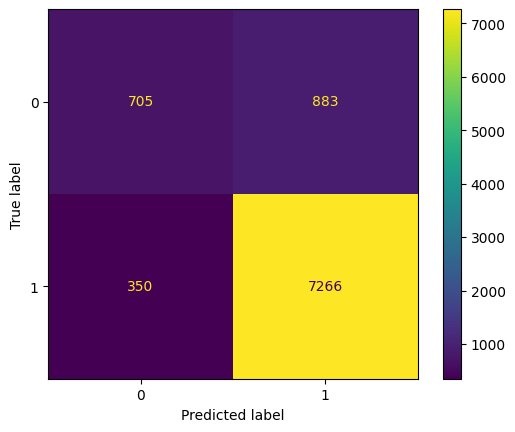

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

lbgmc_best.fit(X_train, y_train)

print(classification_report(y_true=y_test, y_pred=lbgmc_best.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(lbgmc_best, X_test, y_test, normalize=None)

#### Datos balanceados (SMOTE)

              precision    recall  f1-score   support

           0       0.53      0.80      0.63      1588
           1       0.95      0.85      0.90      7616

    accuracy                           0.84      9204
   macro avg       0.74      0.82      0.77      9204
weighted avg       0.88      0.84      0.85      9204



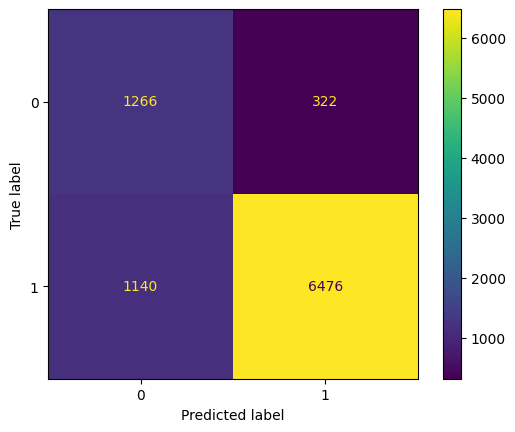

In [70]:
lbgmc_best.fit(X_train_res, y_train_res)

print(classification_report(y_true=y_test, y_pred=lbgmc_best.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(lbgmc_best, X_test, y_test, normalize=None)

Observaciones:
- Se ha decidido realizar el tuneo de hiperparámetros antes de balancear los datos por las siguientes razones:
    1. **Menor tiempo de entrenamiento**: El conjunto de entrenamiento contenía 36813 filas y el mismo conjunto con las muestras sintéticas, 60928 filas! El Random Search elige 50 combinaciones, de las cuales se entrenaran 5 veces por modelo (cv=5); 250 fits en total! Todo ello disparará mucho el coste computacional.

    1. **Posible sobreajuste al ajustar con datos sintéticos**: Queremos que el modelo aprenda patrones de los datos originales, aunque sea desbalanceado (es la realidad de dichos datos). Ajustar hiperparámetros después del remuestreo puede sesgar al modelo con patrones específicos de estos datos balanceados y hacer que no generalize bien a nuevos datos. 
    1. **roc_auc tiene en cuenta tanto la sensitividad como la especificidad del modelo**: Dicha métrica de clasificación no solamente tiene en cuenta sensitivity/True Positive Rate (TPR) sino también False Positive Rate (FPR), el cual está inversamente proporcional a specificity/True Negative Rate (TNR). Cuando TPR aumenta y FPR disminuye, la curva ROC se mueve más hacia la zona superior izquierda, incremento el área bajo dicha curva. Por lo tanto, mejoras de modelos en specificity/True Negative Rate se traducen en roc_auc más altos!

- En relación a los resultados de las predicciones del modelo LightGBM tuneado, **se observan mejoras importantes en la identificación de clase minoritaria en aquellas producidas por el modelo entrenado con datos balanceados**:
    -  Sensitivity/recall for class 0 ha duplicado casi de 0.44 (original) a 0.80 (balanceado).
      
    -  F1 score de la clase minoritaria ha aumentado 0.1 puntos (de 0.53 a 0.63) frente a la disminución del F1 score para la clase mayoritaria de 0.02 (de 0.92 a 0.90).
    -  Evidentemente, esto conlleva a una bajada del accuracy, del 0.87 al 0.84. No obstante, esta penalización es compensada por un gran aumento en la capacidad discriminatoria del modelo entre Cyber-Bullying y Non-Cyberbullying tweets!

## 7. Importancia de Variables

In [71]:
# Definimos función para sacar feature importance de modelos basados en árboles:
#Función personal modificada para ligthGBM y sparse X
def feature_importance_plot(
    tree_predictor,
    n_rows:int=None,
    return_df=False,
    bottom=False,
    figsize=(8,6),
    palette='tab10'
):
    """
    Plot feature importance based on a tree-based predictor.

    Parameters:
    --
    - ``tree_predictor (object)``: A tree-based predictor (e.g., DecisionTreeClassifier, RandomForestRegressor).
    - ``bottom (bool, optional)``: If True, plot the bottom features; if False, plot the top features. Default is False.
    - ``n_rows (int, optional)``: Number of features to include in the plot. If None, all features are included. Default is None.
    - ``figsize (tuple, optional)``: Figure size. Default is (8, 6).
    - ``palette (str or list, optional)``: Color palette for the barplot. Default is 'viridis'.
    - ``return_df (bool, optional)``: Returns the df with feature importance measure (%) and feature names (index). Default is False.
    A subset df of the top or bottom features is possible.
    """
    # Bottom or top features
    if bottom is False:
        sort_type = 'Top'
    else:
        sort_type = 'Bottom'
    
    df_feature = pd.DataFrame({'feature_importance': tree_predictor.feature_importances_},
                              index=X_col_names)
    
    # number of rows/features
    if n_rows:
        n = n_rows
    else: 
        n = df_feature.shape[0]
        
    sub_feature = df_feature.sort_values('feature_importance', ascending=bottom)[:n]
    
    if return_df:
        return sub_feature
    
    plt.figure(figsize=figsize)
    sns.barplot(y=sub_feature.index, x=sub_feature['feature_importance'], palette=palette, hue=sub_feature.index, legend=False)

    for idx, measure in enumerate(sub_feature['feature_importance']):
        plt.annotate(xy=(measure, idx), text=f'{measure:.2f}', fontsize='x-small')

    _, x_right = plt.xlim()
    plt.xlim(right=x_right + 1)
    plt.title(f'Feature importance ({sort_type} {n} out of {df_feature.shape[0]}) | {tree_predictor.__class__.__name__}', fontsize='large')
    
    try:
        criterion = tree_predictor.criterion
    except:
        criterion = 'UNKOWN'
    
    plt.ylabel('Features')
    plt.show()

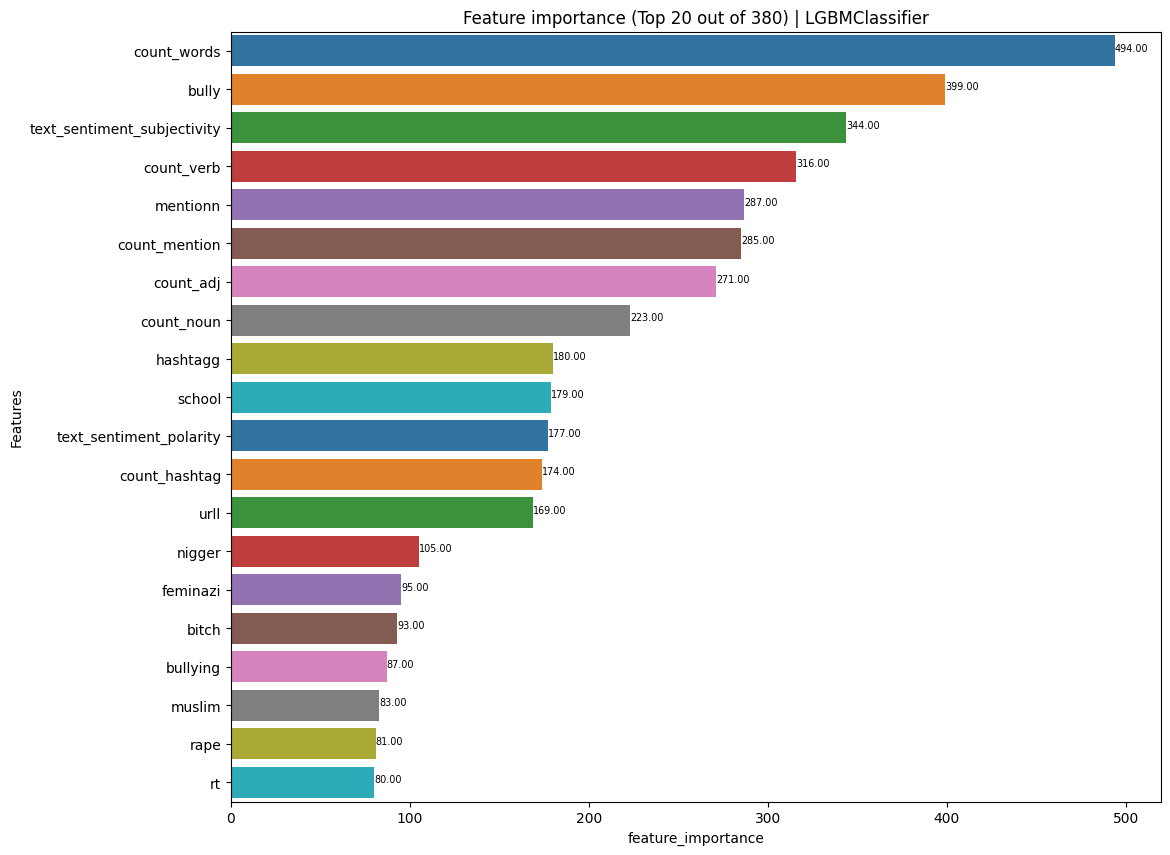

In [72]:
# Mejores 20
feature_importance_plot(
    tree_predictor=lbgmc_best,
    n_rows=20,
    return_df=False,
    bottom=False,
    figsize=(12, 10),
)

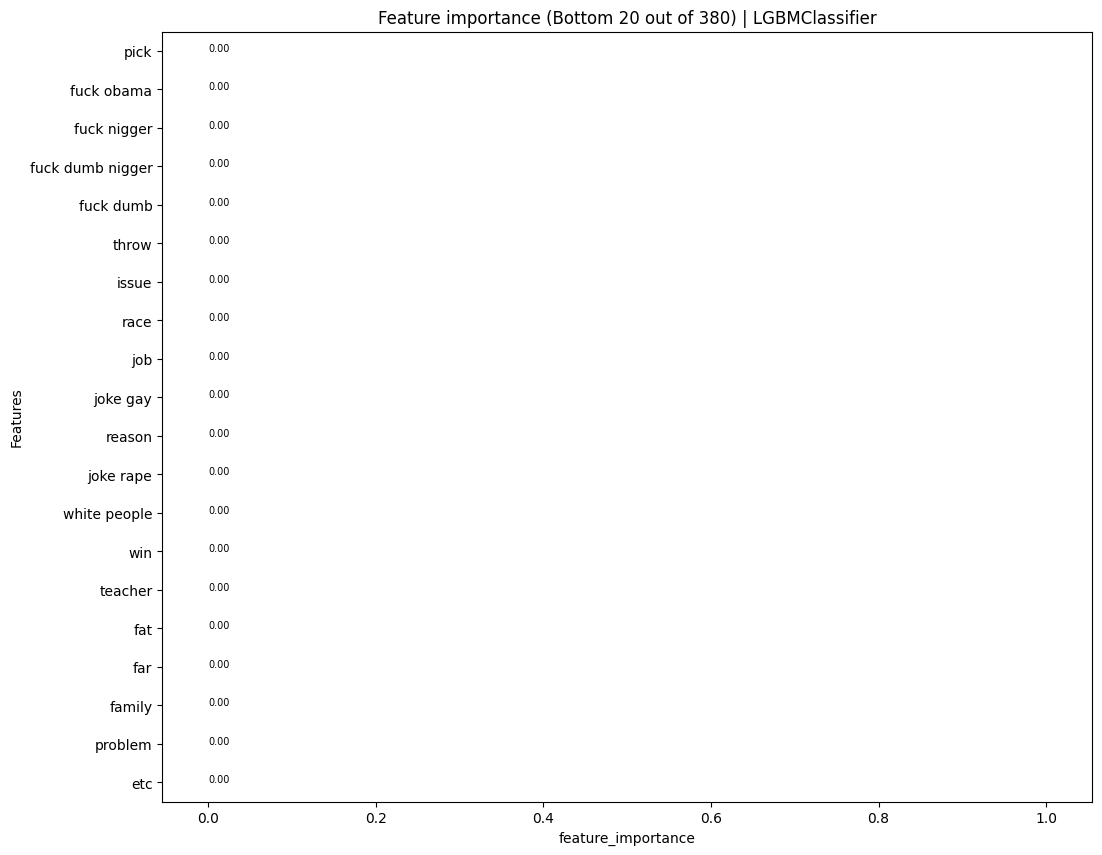

In [73]:
# peores 20
feature_importance_plot(
    tree_predictor=lbgmc_best,
    n_rows=20,
    return_df=False,
    bottom=True,
    figsize=(12, 10),
)

Observaciones:
- **Entre las mejores predictoras, muchas de ellas son características continuas que fueron añadidas en la sección de Feature Engineering**: 'count_words', 'text_sentiment_subjectivity', 'count_verb', 'mentionn', 'count_adj', 'hastagg', etc.
  
    - No es de extrañar puesto que los modelos basados en árboles manejan mejor variables continuas, de las cuales seleccionan/discretizan las mejoras particiones a diferencia de variables binarias (palabras) donde solo pueden elegir partir entre 0 o 1.
- **Dentro de las mejores palabras predictoras** destacan: 'bully', 'school', 'nigger', 'femenazi', 'bitch', 'bullying', 'muslim', 'rape'.
- **De las peores predictoras, abundan collocations/bi-trigramas** como 'fuck obama', 'fuck nigger', 'fuck dumb nigger', 'joke gay', 'fuck dumb', 'white people', etc. Quizás por sus pocas frecuencias.